### S4 프로젝트 : 이미지 프로세싱을 활용하여 자동차 번호판 인식기 프로그래밍

*   아직 스스로 탐구하고 제작할 수 있는 능력이 없어서 복습한다는 차원에서 guthub 및 kaggle 자료를 참고하여 프로그래밍한 내용에 대해 그 의미를 다시 해석하는 차원으로 S4를 제작하였습니다. 
*   S4 주제는 자동차 번호판 인식기 - 이미지 프로세싱으로서, 사진화일을 가지고 번호판을 인식할 수 있는 프로그래밍입니다



* 결론적으로 자동차번호판 인식에는 실패했다. pytesseract 와 tesseract의 사용법을 제대로 인지하지 못함과 동시에 문제의 원인파악을 못한다는 부분이 가장 큰 실패원인이다. 




In [ ]:
!pip install pytesseract

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract  #이미지에서 글씨를 읽어내는 라이브러리
plt.style.use('dark_background')

# Read Input Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


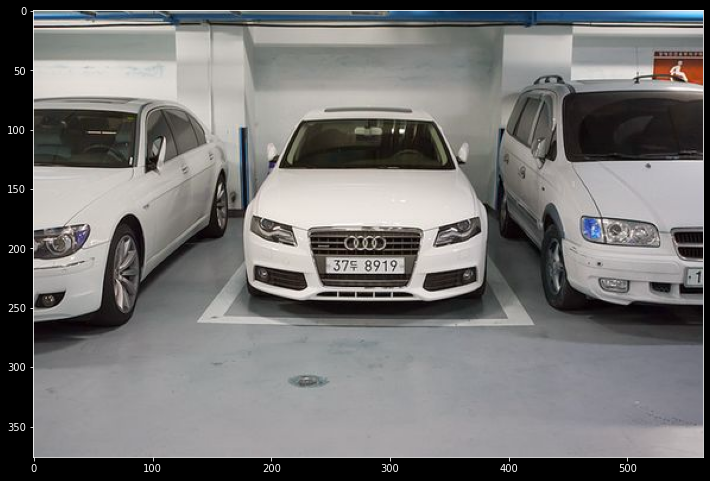

In [4]:
img_ori = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/S4/1.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

# Convert Image to Grayscale

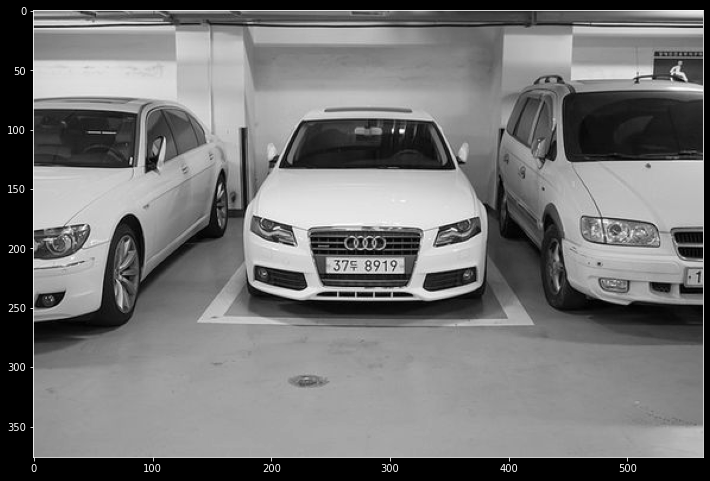

In [5]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY) #색상을 gray로 변환

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Maximize Contrast (Optional)

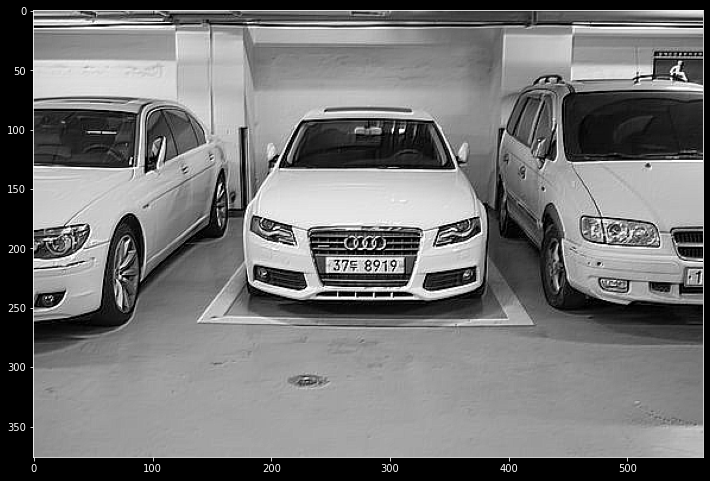

In [6]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Adaptive Thresholding

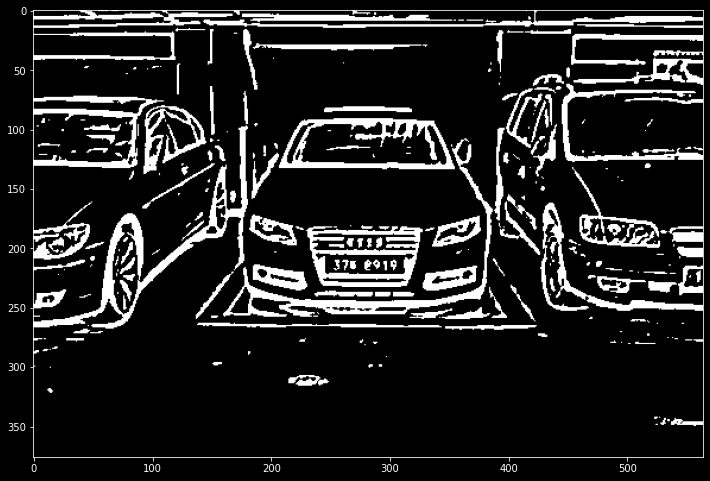

In [7]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)  #노이즈를 없앤다

# 이미지를 구분하기 쉽게 threshold를 적용 : 지정한 threshold 값을 기준으로 정하고 이보다 낮은 값은 0, 높은 값은 255로 변환
img_thresh = cv2.adaptiveThreshold(   
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# Find Contours

In [ ]:
# 윤곽선을 찾는다
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# 윤곽선을 그린다
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))



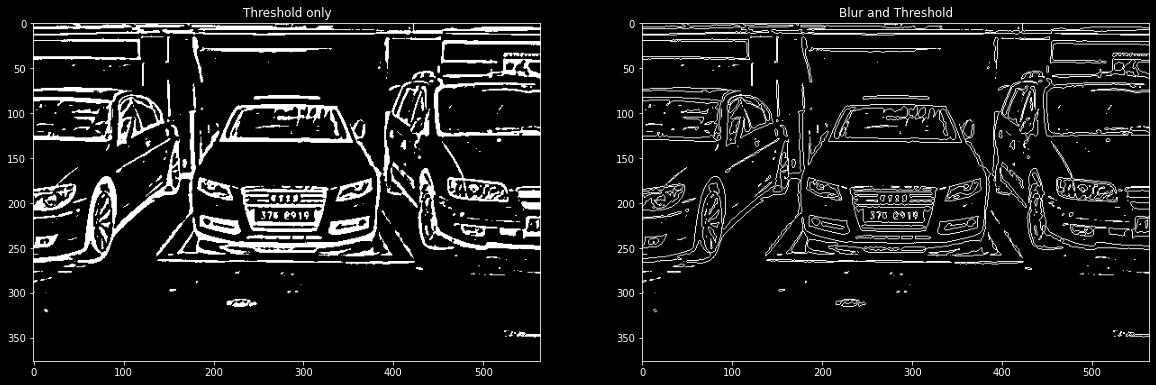

In [9]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Threshold only')
plt.imshow(img_thresh, cmap='gray')
plt.subplot(1,2,2)
plt.title('Blur and Threshold')
plt.imshow(temp_result, cmap='gray')

# Prepare Data

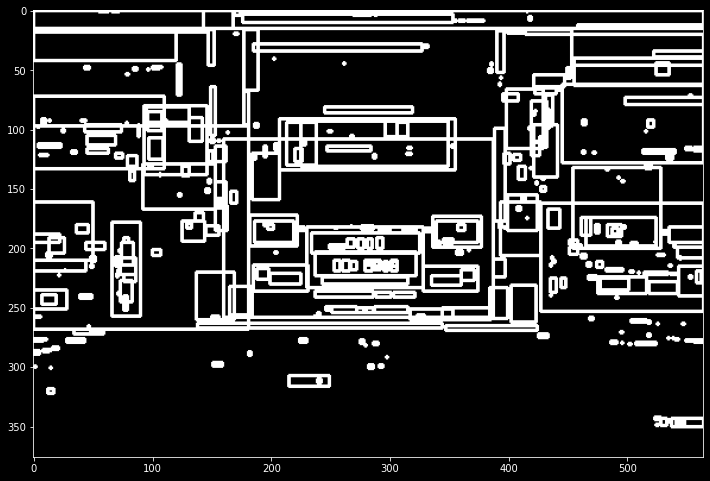

In [10]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []  #윤곽선을 감싸는 사각형을 구한다

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2) 
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Char Size

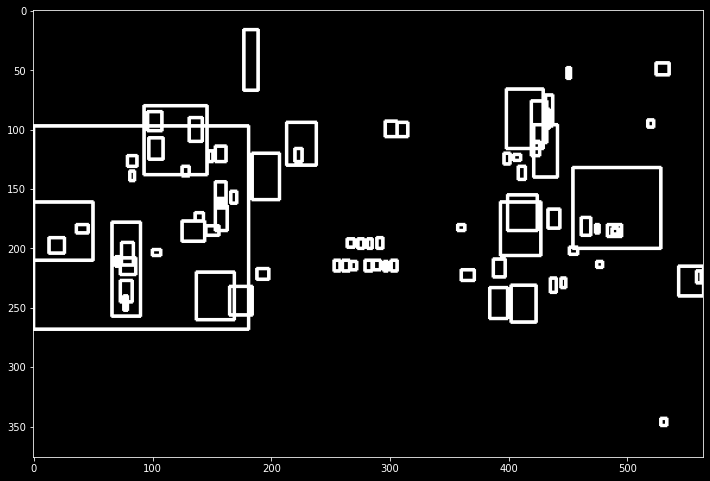

In [11]:
# 구해진 사각형중에서 의미있는 사각형 - 번호판 - 을 구한다


MIN_AREA = 20  #최소넓이
MIN_WIDTH, MIN_HEIGHT = 1, 3
MIN_RATIO, MAX_RATIO = 0.2, 1.5

possible_contours = []  # 번호판일 가능성이 있는 사물을 기록

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']  #넓이
    ratio = d['w'] / d['h'] #비율
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Arrangement of Contours

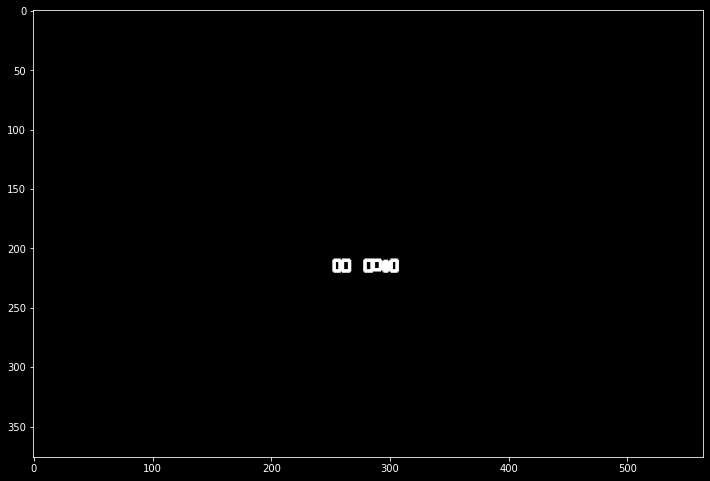

In [12]:
# 위치의 배열을 통해 번호판일 가능성을 찾아낸다


MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0 
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 5 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:  #3보다 작을경우 번호판일 가능성을 배제
            continue

        matched_result_idx.append(matched_contours_idx) #최종 후보군에 넣어준다

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Plate Images

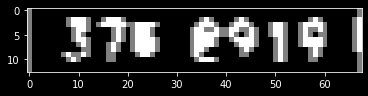

In [13]:
# 기울어진 번호판을 똑바로 돌린다


PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# Another Thresholding to Find Chars

In [14]:
!pip install pillow

In [17]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

In [21]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

AttributeError: ignored

# Result

In [16]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)

IndexError: ignored